In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np; np.set_printoptions(precision=2); np.random.seed(0)
import torch; torch.set_printoptions(precision=2)
seed = 1

torch.manual_seed(seed)
import torch.nn as nn
import matplotlib.pyplot as plt; plt.rc('font', size=12)
import matplotlib 
from matplotlib.font_manager import FontProperties
from mpl_toolkits import mplot3d
import matplotlib.pylab as pl

import seaborn as sns
import time
import sys
import itertools
import random; random.seed(0)
import datetime
import pickle
import copy
import pandas as pd
import scipy
import os

from sklearn.cluster import KMeans
from sklearn.manifold import MDS
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

import sys
sys.path.append("../two_module_rnn/code")
os.chdir('/home/yl4317/Documents/two_module_rnn/code')
from model_working import *
from functions import *

os.chdir('/home/yl4317/Documents/two_module_rnn/')

print(torch.__version__)
print(sys.version)
                
%matplotlib inline

1.13.1+cu116
3.10.8 (main, Nov 24 2022, 14:13:03) [GCC 11.2.0]


# Generate data

In [2]:
start = time.time()

all_data_conn_bias = []

subcg_label_converter = {'rule1_pfc_esoma': 'rule 1 exc', 'rule2_pfc_esoma': 'rule 2 exc', 'rule1_pfc_pv': 'rule 1\n PV', 'rule2_pfc_pv': 'rule 2\n PV', 'mix_err_rule1_pfc_esoma': 'error x rule 1', 
                         'mix_err_rule2_pfc_esoma': 'error x rule 2'}

for condition in ['fast_switching', 'slow_switching']:
    all_data_conn_bias = []
    for model_name in sorted(os.listdir('/scratch/yl4317/two_module_rnn/saved_models/')):
        if (condition == 'fast_switching' and ('2023-05-10' in model_name) and 'success' in model_name) or (condition == 'slow_switching' and ('2023-12-22' in model_name or '2024-01-02' in model_name or '2024-01-04' in model_name) and 'success' in model_name):
            print(model_name+'\n')
            
            # load model
            path_to_file = '/scratch/yl4317/two_module_rnn/saved_models/'+model_name
            with HiddenPrints():
                model, hp_test, hp_task_test, optim, saved_data = load_model_v2(path_to_file=path_to_file, model_name=model_name, simple=False, plot=False, toprint=False)
            if hp_test['dt']!=10:
                continue
            if len(hp_test['cell_group_list'])==2:
                print('only Esoma, pass\n')
                continue
            if hp_test['dend_nonlinearity'] not in ['subtractive', 'divisive_2']:
                continue
    
            # for key in ['dend_nonlinearity', 'sparse_srsst_to_sredend', 'initialization_weights', 'activation']:
            #     print(key, hp_test[key])
    
        
            
            # load test data
            if condition == 'fast_switching':
                appendix = '_testdata_noiseless_no_current_matrix'
            elif condition == 'slow_switching':
                appendix = '_testdata_noiseless_moreblocks_17in20'
            with open('/scratch/yl4317/two_module_rnn/saved_testdata/{}'.format(model_name + appendix), 'rb') as f:
                neural_data = pickle.load(f)
            test_data = neural_data['test_data']
            mean_perf = np.mean([_[0] for _ in test_data['perfs']])
            mean_perf_rule = np.mean([_[0] for _ in test_data['perf_rules']])
            if (condition == 'fast_switching' and (mean_perf<0.8 or mean_perf_rule<0.8)) or (condition == 'slow_switching' and (mean_perf<0.5 or mean_perf_rule<0.5)):
                print('low performing model ({}/{})'.format(mean_perf, mean_perf_rule))
                continue
            rnn_activity = neural_data['rnn_activity'].detach().cpu().numpy()
            
            # generate trial labels
            trial_labels = label_trials_wcst(test_data=test_data)
            rule1_trs_stable = trial_labels['rule1_trs_stable']
            rule2_trs_stable = trial_labels['rule2_trs_stable']
            rule1_trs_after_error = trial_labels['rule1_trs_after_error']
            rule2_trs_after_error = trial_labels['rule2_trs_after_error']
            rule1_trs_after_correct = trial_labels['rule1_trs_after_correct']
            rule2_trs_after_correct = trial_labels['rule2_trs_after_correct']
            c1_trs_stable = trial_labels['c1_trs_stable']
            c2_trs_stable = trial_labels['c2_trs_stable']
            c3_trs_stable = trial_labels['c3_trs_stable']
            resp_trs_stable = {'c1': c1_trs_stable, 'c2': c2_trs_stable, 'c3': c3_trs_stable}    # to be used as an argument in the "compute_sel_wcst" function
            error_trials = trial_labels['error_trials']
                    
            # compute cell selectivity
            all_sels = compute_sel_wcst(rnn_activity=rnn_activity, hp=hp_test, hp_task=hp_task_test, rules=test_data['rules'],
                                         rule1_trs_stable=trial_labels['rule1_trs_stable'], rule2_trs_stable=trial_labels['rule2_trs_stable'],
                                         rule1_trs_after_error = trial_labels['rule1_trs_after_error'], rule2_trs_after_error=trial_labels['rule2_trs_after_error'],
                                         resp_trs_stable = resp_trs_stable, trs_by_center_card=trial_labels['trs_by_center_card_stable'],
                                         stims=test_data['stims'], error_trials=trial_labels['error_trials'], trial_labels=trial_labels)
            
            
            # define subpopulations within PFC
            rule_sel_used = all_sels['rule_normalized_activity']
            error_sel_used = all_sels['error_normalized']
            subcg_pfc_idx = define_subpop_pfc(model=model, hp_task=hp_task_test, hp=hp_test, rnn_activity=rnn_activity, 
                                              rule_sel=rule_sel_used, err_sel=error_sel_used, 
                                              rule1_trs_stable=rule1_trs_stable, rule2_trs_stable=rule2_trs_stable, 
                                              rule1_after_error_trs=rule1_trs_after_error, rule2_after_error_trs=rule2_trs_after_error,
                                              rule1_after_correct_trs=trial_labels['rule1_trs_after_correct'], rule2_after_correct_trs=trial_labels['rule2_trs_after_correct'],
                                              rule_threshold=0.5, err_threshold=0.5, dend_pop='same_as_soma')
            for subcg in subcg_pfc_idx.keys():
                model.rnn.cg_idx['subcg_pfc_'+subcg] = subcg_pfc_idx[subcg]
            
            
            
            # calculate connectivity bias
            w_rec_eff = model.rnn.effective_weight(w=model.rnn.w_rec, mask=model.rnn.mask, w_fix=model.rnn.w_fix).detach().cpu().numpy()
            
            ## structure from rule -> mixerr
            bias_ruleesoma_mixerr_1 = np.mean(w_rec_eff[np.ix_(subcg_pfc_idx['rule1_pfc_esoma'], subcg_pfc_idx['mix_err_rule2_pfc_esoma'])]) - np.mean(w_rec_eff[np.ix_(subcg_pfc_idx['rule1_pfc_esoma'], subcg_pfc_idx['mix_err_rule1_pfc_esoma'])])
            bias_ruleesoma_mixerr_2 = np.mean(w_rec_eff[np.ix_(subcg_pfc_idx['rule2_pfc_esoma'], subcg_pfc_idx['mix_err_rule1_pfc_esoma'])]) - np.mean(w_rec_eff[np.ix_(subcg_pfc_idx['rule2_pfc_esoma'], subcg_pfc_idx['mix_err_rule2_pfc_esoma'])])
            bias_ruleesoma_mixerr = bias_ruleesoma_mixerr_1 + bias_ruleesoma_mixerr_2
            
            bias_rulepv_mixerr_1 = np.mean(w_rec_eff[np.ix_(subcg_pfc_idx['rule1_pfc_pv'], subcg_pfc_idx['mix_err_rule1_pfc_esoma'])]) - np.mean(w_rec_eff[np.ix_(subcg_pfc_idx['rule1_pfc_pv'], subcg_pfc_idx['mix_err_rule2_pfc_esoma'])])
            bias_rulepv_mixerr_2 = np.mean(w_rec_eff[np.ix_(subcg_pfc_idx['rule2_pfc_pv'], subcg_pfc_idx['mix_err_rule2_pfc_esoma'])]) - np.mean(w_rec_eff[np.ix_(subcg_pfc_idx['rule2_pfc_pv'], subcg_pfc_idx['mix_err_rule1_pfc_esoma'])])
            bias_rulepv_mixerr_1 = - bias_rulepv_mixerr_1
            bias_rulepv_mixerr_2 = - bias_rulepv_mixerr_2
            bias_rulepv_mixerr = bias_rulepv_mixerr_1 + bias_rulepv_mixerr_2
            
            bias_rulesst_mixerr_1 = np.mean(w_rec_eff[np.ix_(subcg_pfc_idx['rule1_pfc_sst'], subcg_pfc_idx['mix_err_rule1_pfc_edend'])]) - np.mean(w_rec_eff[np.ix_(subcg_pfc_idx['rule1_pfc_sst'], subcg_pfc_idx['mix_err_rule2_pfc_edend'])])
            bias_rulesst_mixerr_2 = np.mean(w_rec_eff[np.ix_(subcg_pfc_idx['rule2_pfc_sst'], subcg_pfc_idx['mix_err_rule2_pfc_edend'])]) - np.mean(w_rec_eff[np.ix_(subcg_pfc_idx['rule2_pfc_sst'], subcg_pfc_idx['mix_err_rule1_pfc_edend'])])
            bias_rulesst_mixerr_1 = - bias_rulesst_mixerr_1
            bias_rulesst_mixerr_2 = - bias_rulesst_mixerr_2
            bias_rulesst_mixerr = bias_rulesst_mixerr_1 + bias_rulesst_mixerr_2
            
        
            bias_ruletomixerr = np.mean([bias_ruleesoma_mixerr, -bias_rulepv_mixerr])    # average over both biases
            
                
            
            
            ## structure from mixerr -> rule
            bias_mixerr_ruleesoma_1 = np.mean(w_rec_eff[np.ix_(subcg_pfc_idx['mix_err_rule1_pfc_esoma'], subcg_pfc_idx['rule1_pfc_esoma'])]) - np.mean(w_rec_eff[np.ix_(subcg_pfc_idx['mix_err_rule1_pfc_esoma'], subcg_pfc_idx['rule2_pfc_esoma'])])
            bias_mixerr_ruleesoma_2 = np.mean(w_rec_eff[np.ix_(subcg_pfc_idx['mix_err_rule2_pfc_esoma'], subcg_pfc_idx['rule2_pfc_esoma'])]) - np.mean(w_rec_eff[np.ix_(subcg_pfc_idx['mix_err_rule2_pfc_esoma'], subcg_pfc_idx['rule1_pfc_esoma'])])
            bias_mixerr_ruleesoma = bias_mixerr_ruleesoma_1 + bias_mixerr_ruleesoma_2
    
            bias_mixerr_rulepv_1 = np.mean(w_rec_eff[np.ix_(subcg_pfc_idx['mix_err_rule1_pfc_esoma'], subcg_pfc_idx['rule1_pfc_pv'])]) - np.mean(w_rec_eff[np.ix_(subcg_pfc_idx['mix_err_rule1_pfc_esoma'], subcg_pfc_idx['rule2_pfc_pv'])])
            bias_mixerr_rulepv_2 = np.mean(w_rec_eff[np.ix_(subcg_pfc_idx['mix_err_rule2_pfc_esoma'], subcg_pfc_idx['rule2_pfc_pv'])]) - np.mean(w_rec_eff[np.ix_(subcg_pfc_idx['mix_err_rule2_pfc_esoma'], subcg_pfc_idx['rule1_pfc_pv'])])
            bias_mixerr_rulepv = bias_mixerr_rulepv_1 + bias_mixerr_rulepv_2
    
            bias_mixerr_rulesst_1 = np.mean(w_rec_eff[np.ix_(subcg_pfc_idx['mix_err_rule1_pfc_esoma'], subcg_pfc_idx['rule1_pfc_sst'])]) - np.mean(w_rec_eff[np.ix_(subcg_pfc_idx['mix_err_rule1_pfc_esoma'], subcg_pfc_idx['rule2_pfc_sst'])])
            bias_mixerr_rulesst_2 = np.mean(w_rec_eff[np.ix_(subcg_pfc_idx['mix_err_rule2_pfc_esoma'], subcg_pfc_idx['rule2_pfc_sst'])]) - np.mean(w_rec_eff[np.ix_(subcg_pfc_idx['mix_err_rule2_pfc_esoma'], subcg_pfc_idx['rule1_pfc_sst'])])
            bias_mixerr_rulesst = bias_mixerr_rulesst_1 + bias_mixerr_rulesst_2
            
            bias_mixerrtorule = np.mean([bias_mixerr_ruleesoma, bias_mixerr_rulepv])    # average over both biases
                
            
            
            ## structure from mixcorr -> rule
            bias_mixcorr_ruleesoma_1 = np.mean(w_rec_eff[np.ix_(subcg_pfc_idx['mix_corr_rule1_pfc_esoma'], subcg_pfc_idx['rule1_pfc_esoma'])]) - np.mean(w_rec_eff[np.ix_(subcg_pfc_idx['mix_corr_rule1_pfc_esoma'], subcg_pfc_idx['rule2_pfc_esoma'])])
            bias_mixcorr_ruleesoma_2 = np.mean(w_rec_eff[np.ix_(subcg_pfc_idx['mix_corr_rule2_pfc_esoma'], subcg_pfc_idx['rule2_pfc_esoma'])]) - np.mean(w_rec_eff[np.ix_(subcg_pfc_idx['mix_corr_rule2_pfc_esoma'], subcg_pfc_idx['rule1_pfc_esoma'])])
            bias_mixcorr_ruleesoma = bias_mixcorr_ruleesoma_1 + bias_mixcorr_ruleesoma_2
    
            bias_mixcorr_rulepv_1 = np.mean(w_rec_eff[np.ix_(subcg_pfc_idx['mix_corr_rule1_pfc_esoma'], subcg_pfc_idx['rule1_pfc_pv'])]) - np.mean(w_rec_eff[np.ix_(subcg_pfc_idx['mix_corr_rule1_pfc_esoma'], subcg_pfc_idx['rule2_pfc_pv'])])
            bias_mixcorr_rulepv_2 = np.mean(w_rec_eff[np.ix_(subcg_pfc_idx['mix_corr_rule2_pfc_esoma'], subcg_pfc_idx['rule2_pfc_pv'])]) - np.mean(w_rec_eff[np.ix_(subcg_pfc_idx['mix_corr_rule2_pfc_esoma'], subcg_pfc_idx['rule1_pfc_pv'])])
            bias_mixcorr_rulepv = bias_mixcorr_rulepv_1 + bias_mixcorr_rulepv_2
            
            bias_mixcorr_rulesst_1 = np.mean(w_rec_eff[np.ix_(subcg_pfc_idx['mix_corr_rule1_pfc_esoma'], subcg_pfc_idx['rule1_pfc_sst'])]) - np.mean(w_rec_eff[np.ix_(subcg_pfc_idx['mix_corr_rule1_pfc_esoma'], subcg_pfc_idx['rule2_pfc_sst'])])
            bias_mixcorr_rulesst_2 = np.mean(w_rec_eff[np.ix_(subcg_pfc_idx['mix_corr_rule2_pfc_esoma'], subcg_pfc_idx['rule2_pfc_sst'])]) - np.mean(w_rec_eff[np.ix_(subcg_pfc_idx['mix_corr_rule2_pfc_esoma'], subcg_pfc_idx['rule1_pfc_sst'])])
            bias_mixcorr_rulesst = bias_mixcorr_rulesst_1 + bias_mixcorr_rulesst_2
            
            bias_mixcorrtorule = np.mean([bias_mixcorr_ruleesoma, bias_mixcorr_rulepv])    # average over both biases
            
            
            ## structure from rule -> mixcorr 
            bias_ruleesoma_mixcorr_1 = np.mean(w_rec_eff[np.ix_(subcg_pfc_idx['rule1_pfc_esoma'], subcg_pfc_idx['mix_corr_rule1_pfc_esoma'])]) - np.mean(w_rec_eff[np.ix_(subcg_pfc_idx['rule1_pfc_esoma'], subcg_pfc_idx['mix_corr_rule2_pfc_esoma'])])
            bias_ruleesoma_mixcorr_2 = np.mean(w_rec_eff[np.ix_(subcg_pfc_idx['rule2_pfc_esoma'], subcg_pfc_idx['mix_corr_rule2_pfc_esoma'])]) - np.mean(w_rec_eff[np.ix_(subcg_pfc_idx['rule2_pfc_esoma'], subcg_pfc_idx['mix_corr_rule1_pfc_esoma'])])
            bias_ruleesoma_mixcorr = bias_ruleesoma_mixcorr_1 + bias_ruleesoma_mixcorr_2
            
            bias_rulepv_mixcorr_1 = np.mean(w_rec_eff[np.ix_(subcg_pfc_idx['rule1_pfc_pv'], subcg_pfc_idx['mix_corr_rule2_pfc_esoma'])]) - np.mean(w_rec_eff[np.ix_(subcg_pfc_idx['rule1_pfc_pv'], subcg_pfc_idx['mix_corr_rule1_pfc_esoma'])])
            bias_rulepv_mixcorr_2 = np.mean(w_rec_eff[np.ix_(subcg_pfc_idx['rule2_pfc_pv'], subcg_pfc_idx['mix_corr_rule1_pfc_esoma'])]) - np.mean(w_rec_eff[np.ix_(subcg_pfc_idx['rule2_pfc_pv'], subcg_pfc_idx['mix_corr_rule2_pfc_esoma'])])
            bias_rulepv_mixcorr_1 = - bias_rulepv_mixcorr_1
            bias_rulepv_mixcorr_2 = - bias_rulepv_mixcorr_2
            bias_rulepv_mixcorr = bias_rulepv_mixcorr_1 + bias_rulepv_mixcorr_2
            
            bias_rulesst_mixcorr_1 = np.mean(w_rec_eff[np.ix_(subcg_pfc_idx['rule1_pfc_sst'], subcg_pfc_idx['mix_corr_rule2_pfc_edend'])]) - np.mean(w_rec_eff[np.ix_(subcg_pfc_idx['rule1_pfc_sst'], subcg_pfc_idx['mix_corr_rule1_pfc_edend'])])
            bias_rulesst_mixcorr_2 = np.mean(w_rec_eff[np.ix_(subcg_pfc_idx['rule2_pfc_sst'], subcg_pfc_idx['mix_corr_rule1_pfc_edend'])]) - np.mean(w_rec_eff[np.ix_(subcg_pfc_idx['rule2_pfc_sst'], subcg_pfc_idx['mix_corr_rule2_pfc_edend'])])
            bias_rulesst_mixcorr_1 = - bias_rulesst_mixcorr_1
            bias_rulesst_mixcorr_2 = - bias_rulesst_mixcorr_2
            bias_rulesst_mixcorr = bias_rulesst_mixcorr_1 + bias_rulesst_mixcorr_2
        
            bias_ruletomixcorr = np.mean([bias_ruleesoma_mixcorr, -bias_rulepv_mixcorr])    # average over both biases
            
            
            
            
            # bias within rule network
            rule_subregion = ['rule1_pfc_esoma', 'rule2_pfc_esoma', 'rule1_pfc_pv', 'rule2_pfc_pv']
            
            ## from rule_esoma to rule_esoma
            bias_ruleesoma_ruleesoma_1 = np.mean(w_rec_eff[np.ix_(subcg_pfc_idx['rule1_pfc_esoma'], subcg_pfc_idx['rule1_pfc_esoma'])]) - np.mean(w_rec_eff[np.ix_(subcg_pfc_idx['rule1_pfc_esoma'], subcg_pfc_idx['rule2_pfc_esoma'])])
            bias_ruleesoma_ruleesoma_2 = np.mean(w_rec_eff[np.ix_(subcg_pfc_idx['rule2_pfc_esoma'], subcg_pfc_idx['rule2_pfc_esoma'])]) - np.mean(w_rec_eff[np.ix_(subcg_pfc_idx['rule2_pfc_esoma'], subcg_pfc_idx['rule1_pfc_esoma'])])
            bias_ruleesoma_ruleesoma = bias_ruleesoma_ruleesoma_1 + bias_ruleesoma_ruleesoma_2
            
            ## from rule_esoma to rule_pv
            bias_ruleesoma_rulepv_1 = np.mean(w_rec_eff[np.ix_(subcg_pfc_idx['rule1_pfc_esoma'], subcg_pfc_idx['rule1_pfc_pv'])]) - np.mean(w_rec_eff[np.ix_(subcg_pfc_idx['rule1_pfc_esoma'], subcg_pfc_idx['rule2_pfc_pv'])])
            bias_ruleesoma_rulepv_2 = np.mean(w_rec_eff[np.ix_(subcg_pfc_idx['rule2_pfc_esoma'], subcg_pfc_idx['rule2_pfc_pv'])]) - np.mean(w_rec_eff[np.ix_(subcg_pfc_idx['rule2_pfc_esoma'], subcg_pfc_idx['rule1_pfc_pv'])])
            bias_ruleesoma_rulepv = bias_ruleesoma_rulepv_1 + bias_ruleesoma_rulepv_2
    
            ## from rule_pv to rule_esoma
            bias_rulepv_ruleesoma_1 = np.mean(w_rec_eff[np.ix_(subcg_pfc_idx['rule1_pfc_pv'], subcg_pfc_idx['rule2_pfc_esoma'])]) - np.mean(w_rec_eff[np.ix_(subcg_pfc_idx['rule1_pfc_pv'], subcg_pfc_idx['rule1_pfc_esoma'])])
            bias_rulepv_ruleesoma_2 = np.mean(w_rec_eff[np.ix_(subcg_pfc_idx['rule2_pfc_pv'], subcg_pfc_idx['rule1_pfc_esoma'])]) - np.mean(w_rec_eff[np.ix_(subcg_pfc_idx['rule2_pfc_pv'], subcg_pfc_idx['rule2_pfc_esoma'])])
            bias_rulepv_ruleesoma_1 = - bias_rulepv_ruleesoma_1
            bias_rulepv_ruleesoma_2 = - bias_rulepv_ruleesoma_2
            bias_rulepv_ruleesoma = bias_rulepv_ruleesoma_1 + bias_rulepv_ruleesoma_2
            
            ## from rule_pv to rule_pv
            bias_rulepv_rulepv_1 = np.mean(w_rec_eff[np.ix_(subcg_pfc_idx['rule1_pfc_pv'], subcg_pfc_idx['rule2_pfc_pv'])]) - np.mean(w_rec_eff[np.ix_(subcg_pfc_idx['rule1_pfc_pv'], subcg_pfc_idx['rule1_pfc_pv'])])
            bias_rulepv_rulepv_2 = np.mean(w_rec_eff[np.ix_(subcg_pfc_idx['rule2_pfc_pv'], subcg_pfc_idx['rule1_pfc_pv'])]) - np.mean(w_rec_eff[np.ix_(subcg_pfc_idx['rule2_pfc_pv'], subcg_pfc_idx['rule2_pfc_pv'])])
            bias_rulepv_rulepv_1 = - bias_rulepv_rulepv_1
            bias_rulepv_rulepv_2 = - bias_rulepv_rulepv_2
            bias_rulepv_rulepv = bias_rulepv_rulepv_1 + bias_rulepv_rulepv_2
            
            ## from rule SST to rule E
            bias_rulesst_ruleedend_1 = np.mean(w_rec_eff[np.ix_(subcg_pfc_idx['rule1_pfc_sst'], subcg_pfc_idx['rule2_pfc_edend'])]) - np.mean(w_rec_eff[np.ix_(subcg_pfc_idx['rule1_pfc_sst'], subcg_pfc_idx['rule1_pfc_edend'])])
            bias_rulesst_ruleedend_2 = np.mean(w_rec_eff[np.ix_(subcg_pfc_idx['rule2_pfc_sst'], subcg_pfc_idx['rule1_pfc_edend'])]) - np.mean(w_rec_eff[np.ix_(subcg_pfc_idx['rule2_pfc_sst'], subcg_pfc_idx['rule2_pfc_edend'])])
            bias_rulesst_ruleedend_1 = - bias_rulesst_ruleedend_1
            bias_rulesst_ruleedend_2 = - bias_rulesst_ruleedend_2
            bias_rulesst_ruleedend = bias_rulesst_ruleedend_1 + bias_rulesst_ruleedend_2
            
            ## from rule E to rule SST
            bias_ruleesoma_rulesst_1 = np.mean(w_rec_eff[np.ix_(subcg_pfc_idx['rule1_pfc_esoma'], subcg_pfc_idx['rule1_pfc_sst'])]) - np.mean(w_rec_eff[np.ix_(subcg_pfc_idx['rule1_pfc_esoma'], subcg_pfc_idx['rule2_pfc_sst'])])
            bias_ruleesoma_rulesst_2 = np.mean(w_rec_eff[np.ix_(subcg_pfc_idx['rule2_pfc_esoma'], subcg_pfc_idx['rule2_pfc_sst'])]) - np.mean(w_rec_eff[np.ix_(subcg_pfc_idx['rule2_pfc_esoma'], subcg_pfc_idx['rule1_pfc_sst'])])
            bias_ruleesoma_rulesst = bias_ruleesoma_rulesst_1 + bias_ruleesoma_rulesst_2
            
            ## from rule SST to rule PV
            bias_rulesst_rulepv_1 = np.mean(w_rec_eff[np.ix_(subcg_pfc_idx['rule1_pfc_sst'], subcg_pfc_idx['rule2_pfc_pv'])]) - np.mean(w_rec_eff[np.ix_(subcg_pfc_idx['rule1_pfc_sst'], subcg_pfc_idx['rule1_pfc_pv'])])
            bias_rulesst_rulepv_2 = np.mean(w_rec_eff[np.ix_(subcg_pfc_idx['rule2_pfc_sst'], subcg_pfc_idx['rule1_pfc_pv'])]) - np.mean(w_rec_eff[np.ix_(subcg_pfc_idx['rule2_pfc_sst'], subcg_pfc_idx['rule2_pfc_pv'])])
            bias_rulesst_rulepv_1 = - bias_rulesst_rulepv_1
            bias_rulesst_rulepv_2 = - bias_rulesst_rulepv_2
            bias_rulesst_rulepv= bias_rulesst_rulepv_1 + bias_rulesst_rulepv_2
        
                 
                
            all_data_conn_bias.append({'model': model_name, 
                                       'hp': hp_test,
                                       'w_rec_eff': w_rec_eff,
                                       'bias_ruleesoma_mixerr': bias_ruleesoma_mixerr,
                                       'bias_rulepv_mixerr': bias_rulepv_mixerr,
                                       'bias_rulesst_mixerr': bias_rulesst_mixerr,
                                       'bias_ruletomixerr': bias_ruletomixerr,
                                       'bias_ruleesoma_mixcorr': bias_ruleesoma_mixcorr,
                                       'bias_rulepv_mixcorr': bias_rulepv_mixcorr,
                                       'bias_rulesst_mixcorr': bias_rulesst_mixcorr,
                                       'bias_mixerr_ruleesoma': bias_mixerr_ruleesoma,
                                       'bias_mixerr_rulepv': bias_mixerr_rulepv,
                                       'bias_mixerr_rulesst': bias_mixerr_rulesst,
                                       'bias_mixerrtorule': bias_mixerrtorule,
                                       'bias_mixcorr_ruleesoma': bias_mixcorr_ruleesoma,
                                       'bias_mixcorr_rulepv': bias_mixcorr_rulepv,
                                       'bias_mixcorr_rulesst': bias_mixcorr_rulesst,
                                       'bias_ruleesoma_ruleesoma': bias_ruleesoma_ruleesoma,
                                       'bias_ruleesoma_rulepv': bias_ruleesoma_rulepv,
                                       'bias_rulepv_ruleesoma': bias_rulepv_ruleesoma,
                                       'bias_rulepv_rulepv': bias_rulepv_rulepv,
                                       'bias_rulesst_ruleedend': bias_rulesst_ruleedend,
                                       'bias_ruleesoma_rulesst': bias_ruleesoma_rulesst,
                                       'bias_rulesst_rulepv': bias_rulesst_rulepv,
                                       'subcg_pfc_idx': subcg_pfc_idx})

    # with open('/home/yl4317/Documents/two_module_rnn/processed_data/conn_bias_{}.pickle'.format(condition), 'wb') as handle:
    #     pickle.dump(all_data_conn_bias, handle, protocol=pickle.HIGHEST_PROTOCOL)
              
        
        
        

print(time.time()-start)

success_2023-05-10-14-28-42_wcst_105_sparsity0



/home/yl4317/Documents/two_module_rnn/code/functions.py:2588: RuntimeWarning: invalid value encountered in divide
  rule_sel_across_time[n] = (act_rule1_time - act_rule2_time)/(np.abs(act_rule1_time) + np.abs(act_rule2_time))
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  rule_sel_fdbk = (act_rule1_fdbk - act_rule2_fdbk)/(np.abs(act_rule1_fdbk) + np.abs(act_rule2_fdbk))
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  rule_sel_iti = (act_rule1_iti - act_rule2_iti)/(np.abs(act_rule1_iti) + np.abs(act_rule2_iti))
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  rule_sel_ref_card = (act_rule1_ref_card - act_rule2_ref_card)/(np.abs(act_rule1_ref_card) + np.abs(act_rule2_ref_card))
/home/yl4317/Documents/two_module_rnn/code/functions.py:2610: RuntimeWarning: invalid valu

success_2023-05-10-14-28-42_wcst_106_sparsity0

success_2023-05-10-14-28-42_wcst_10_sparsity0

success_2023-05-10-14-28-42_wcst_112_sparsity0

low performing model (0.0/0.0)
success_2023-05-10-14-28-42_wcst_115_sparsity0

low performing model (0.125/0.02500000037252903)
success_2023-05-10-14-28-42_wcst_116_sparsity0

success_2023-05-10-14-28-42_wcst_118_sparsity0

success_2023-05-10-14-28-42_wcst_121_sparsity0



KeyboardInterrupt: 

# Figure 3a-b: connectivity matrix of an example network

In [4]:
with open('/home/yl4317/Documents/two_module_rnn/processed_data/conn_bias_fast_switching.pickle', 'rb') as handle:
    conn_bias_across_networks = pickle.load(handle)

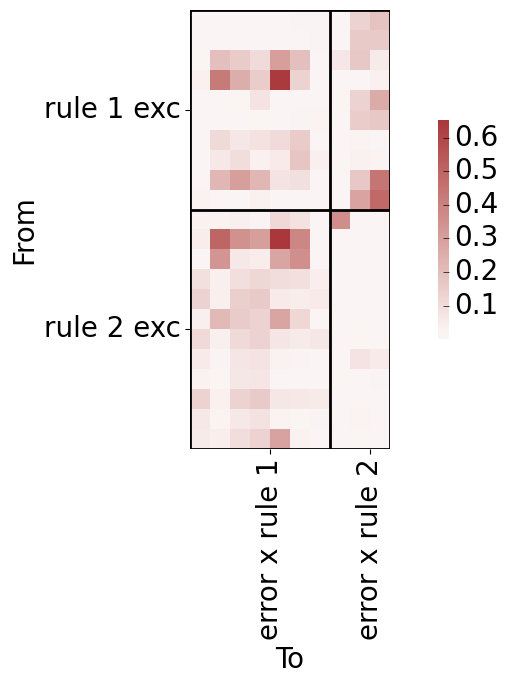

mean weight from rule1_pfc_esoma to mix_err_rule1_pfc_esoma: 0.06964278221130371
mean weight from rule1_pfc_esoma to mix_err_rule2_pfc_esoma: 0.10504390299320221
mean weight from rule2_pfc_esoma to mix_err_rule1_pfc_esoma: 0.10061632096767426
mean weight from rule2_pfc_esoma to mix_err_rule2_pfc_esoma: 0.017890745773911476


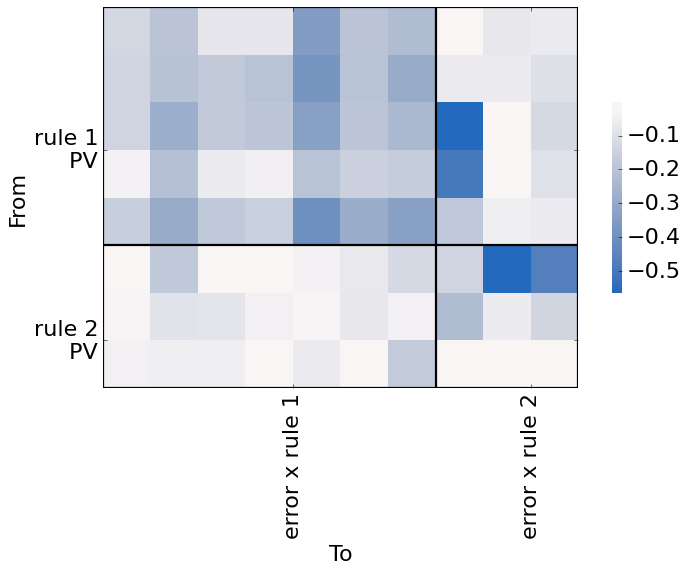

mean weight from rule1_pfc_pv to mix_err_rule1_pfc_esoma: -0.2037809193134308
mean weight from rule1_pfc_pv to mix_err_rule2_pfc_esoma: -0.1330605298280716
mean weight from rule2_pfc_pv to mix_err_rule1_pfc_esoma: -0.05943002179265022
mean weight from rule2_pfc_pv to mix_err_rule2_pfc_esoma: -0.17911279201507568


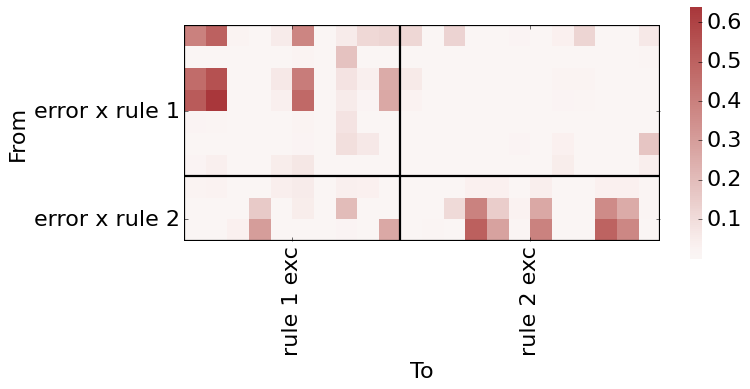

mean weight from mix_err_rule1_pfc_esoma to rule1_pfc_esoma: 0.08960379660129547
mean weight from mix_err_rule1_pfc_esoma to rule2_pfc_esoma: 0.012668067589402199
mean weight from mix_err_rule2_pfc_esoma to rule1_pfc_esoma: 0.04289062321186066
mean weight from mix_err_rule2_pfc_esoma to rule2_pfc_esoma: 0.10807258635759354


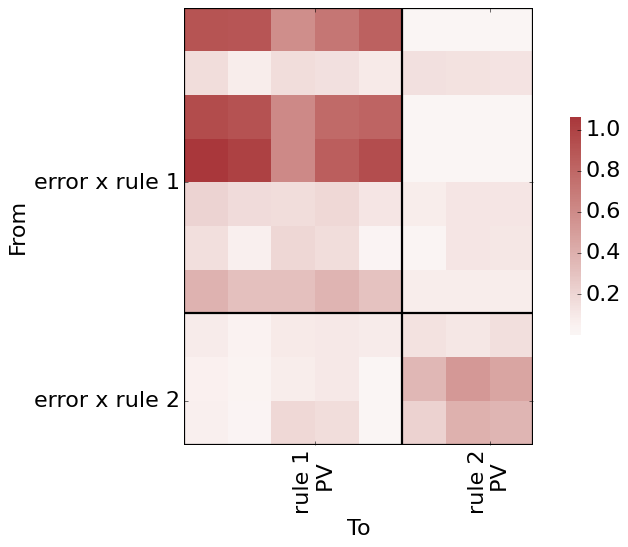

mean weight from mix_err_rule1_pfc_esoma to rule1_pfc_pv: 0.46572479605674744
mean weight from mix_err_rule1_pfc_esoma to rule2_pfc_pv: 0.05893722176551819
mean weight from mix_err_rule2_pfc_esoma to rule1_pfc_pv: 0.07659777253866196
mean weight from mix_err_rule2_pfc_esoma to rule2_pfc_pv: 0.30611732602119446


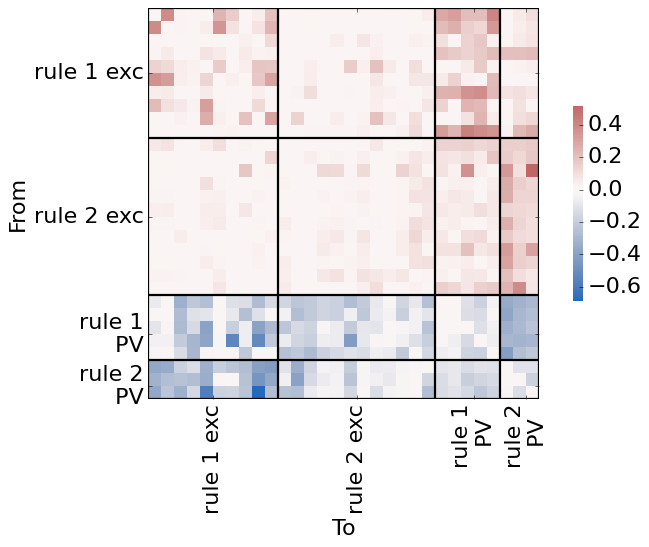

mean weight from rule1_pfc_esoma to rule1_pfc_esoma: 0.07270251214504242
mean weight from rule1_pfc_esoma to rule2_pfc_esoma: 0.02306755818426609
mean weight from rule1_pfc_esoma to rule1_pfc_pv: 0.1768537014722824
mean weight from rule1_pfc_esoma to rule2_pfc_pv: 0.0761607214808464
mean weight from rule2_pfc_esoma to rule1_pfc_esoma: 0.018658654764294624
mean weight from rule2_pfc_esoma to rule2_pfc_esoma: 0.029756566509604454
mean weight from rule2_pfc_esoma to rule1_pfc_pv: 0.07549668848514557
mean weight from rule2_pfc_esoma to rule2_pfc_pv: 0.1844431757926941
mean weight from rule1_pfc_pv to rule1_pfc_esoma: -0.15112172067165375
mean weight from rule1_pfc_pv to rule2_pfc_esoma: -0.13959352672100067
mean weight from rule1_pfc_pv to rule1_pfc_pv: -0.06413386017084122
mean weight from rule1_pfc_pv to rule2_pfc_pv: -0.30517497658729553
mean weight from rule2_pfc_pv to rule1_pfc_esoma: -0.2888425290584564
mean weight from rule2_pfc_pv to rule2_pfc_esoma: -0.105953149497509
mean weight 

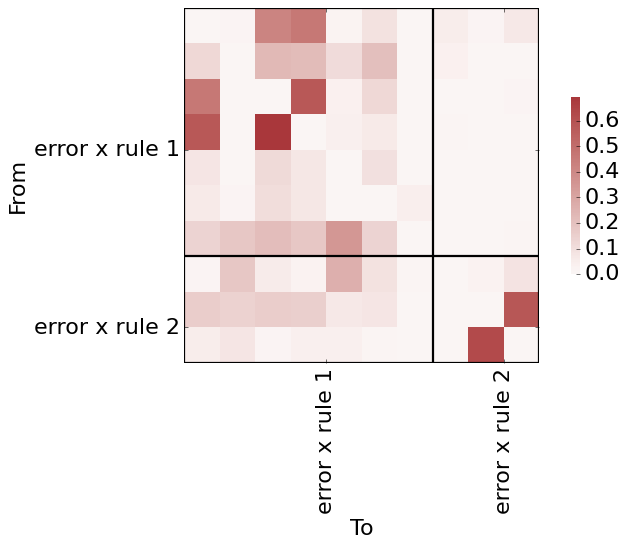

mean weight from mix_err_rule1_pfc_esoma to mix_err_rule1_pfc_esoma: 0.13022087514400482
mean weight from mix_err_rule1_pfc_esoma to mix_err_rule2_pfc_esoma: 0.013020718470215797
mean weight from mix_err_rule2_pfc_esoma to mix_err_rule1_pfc_esoma: 0.07959524542093277
mean weight from mix_err_rule2_pfc_esoma to mix_err_rule2_pfc_esoma: 0.14799965918064117


In [4]:
data_fig3ab = dict.fromkeys(['w_rec', 'neuron_idx'])

for x in conn_bias_across_networks:
    if x['model'] != 'success_2023-05-10-14-28-42_wcst_57_sparsity0':    # this is the example network shown in the paper
        continue
        
    w_rec_eff = x['w_rec_eff']
    subcg_pfc_idx = x['subcg_pfc_idx']

    # plot 
    fig, ax = plot_conn_subpop(weight=w_rec_eff, cg_idx=subcg_pfc_idx, subcg_to_plot_sender=['rule1_pfc_esoma', 'rule2_pfc_esoma'], subcg_to_plot_receiver=['mix_err_rule1_pfc_esoma', 'mix_err_rule2_pfc_esoma'], subcg_label_converter=subcg_label_converter)
    # fig.savefig('/home/yl4317/Documents/two_module_rnn/figs/conn_example_ruleE_to_errorxrule.pdf')
    fig, ax = plot_conn_subpop(weight=w_rec_eff, cg_idx=subcg_pfc_idx, subcg_to_plot_sender=['rule1_pfc_pv', 'rule2_pfc_pv'], subcg_to_plot_receiver=['mix_err_rule1_pfc_esoma', 'mix_err_rule2_pfc_esoma'], subcg_label_converter=subcg_label_converter)
    # fig.savefig('/home/yl4317/Documents/two_module_rnn/figs/conn_example_rulePV_to_errorxrule.pdf')
    fig, ax = plot_conn_subpop(weight=w_rec_eff, cg_idx=subcg_pfc_idx, subcg_to_plot_sender=['mix_err_rule1_pfc_esoma', 'mix_err_rule2_pfc_esoma'], subcg_to_plot_receiver=['rule1_pfc_esoma', 'rule2_pfc_esoma'], subcg_label_converter=subcg_label_converter)
    # fig.savefig('/home/yl4317/Documents/two_module_rnn/figs/conn_example_errorxrule_to_ruleE.pdf')
    fig, ax = plot_conn_subpop(weight=w_rec_eff, cg_idx=subcg_pfc_idx, subcg_to_plot_sender=['mix_err_rule1_pfc_esoma', 'mix_err_rule2_pfc_esoma'], subcg_to_plot_receiver=['rule1_pfc_pv', 'rule2_pfc_pv'], subcg_label_converter=subcg_label_converter)
    # fig.savefig('/home/yl4317/Documents/two_module_rnn/figs/conn_example_errorxrule_to_rulePV.pdf')
    fig, ax = plot_conn_subpop(weight=w_rec_eff, cg_idx=subcg_pfc_idx, subcg_to_plot_sender = rule_subregion, subcg_to_plot_receiver=rule_subregion, subcg_label_converter=subcg_label_converter)
    # fig.savefig('/home/yl4317/Documents/two_module_rnn/figs/conn_example_rule_to_rule.pdf')
    fig, ax = plot_conn_subpop(weight=w_rec_eff, cg_idx=subcg_pfc_idx, subcg_to_plot_sender=['mix_err_rule1_pfc_esoma', 'mix_err_rule2_pfc_esoma'], subcg_to_plot_receiver=['mix_err_rule1_pfc_esoma', 'mix_err_rule2_pfc_esoma'], subcg_label_converter=subcg_label_converter)

    # source data
    data_fig3ab['w_rec'] = w_rec_eff
    data_fig3ab['neuron_idx'] = subcg_pfc_idx



# save to csv
# pd.DataFrame(data=data_fig3ab['w_rec']).to_csv('/home/yl4317/Documents/two_module_rnn/source_data/fig3ab_matrix.csv', header=False)
# pd.DataFrame.from_dict(data=data_fig3ab['neuron_idx'], orient='index').to_csv('/home/yl4317/Documents/two_module_rnn/source_data/fig3ab_neuron_idx.csv', header=False)

# Figure 3d and Supplementary Figure 4: connectivity biases

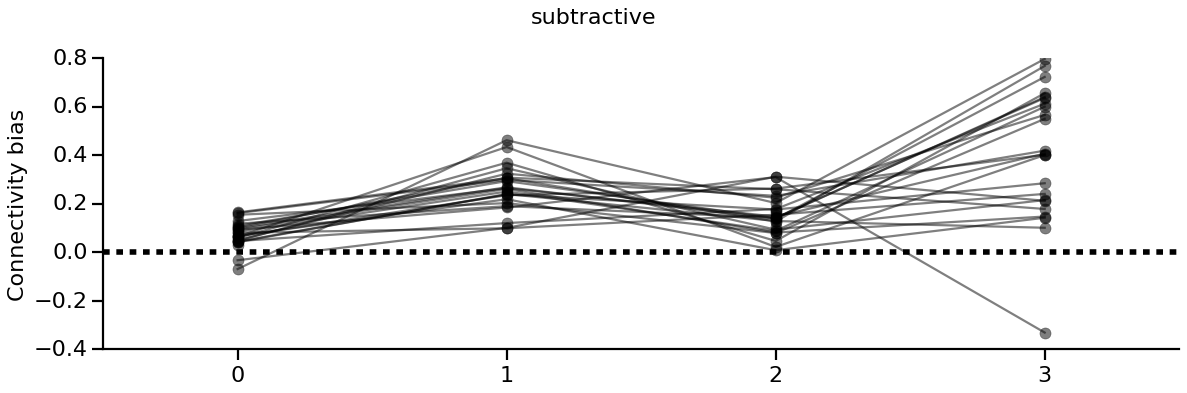

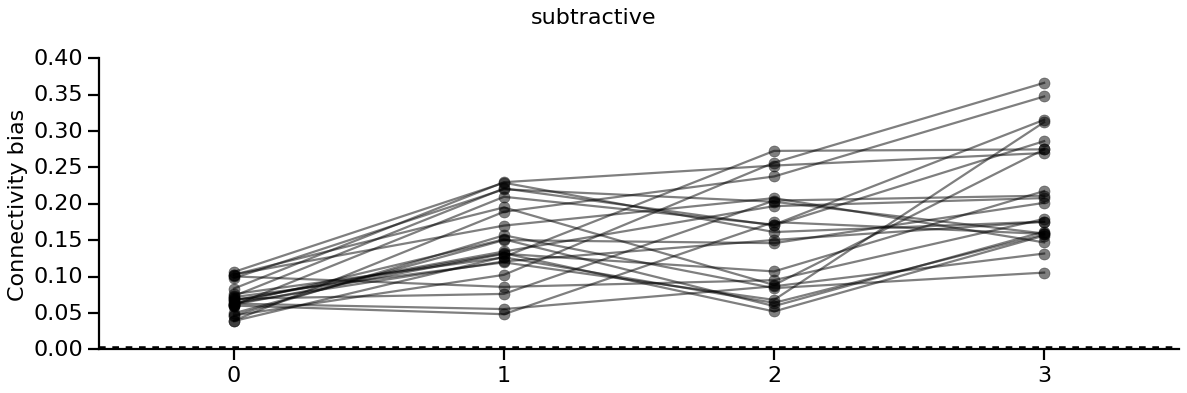

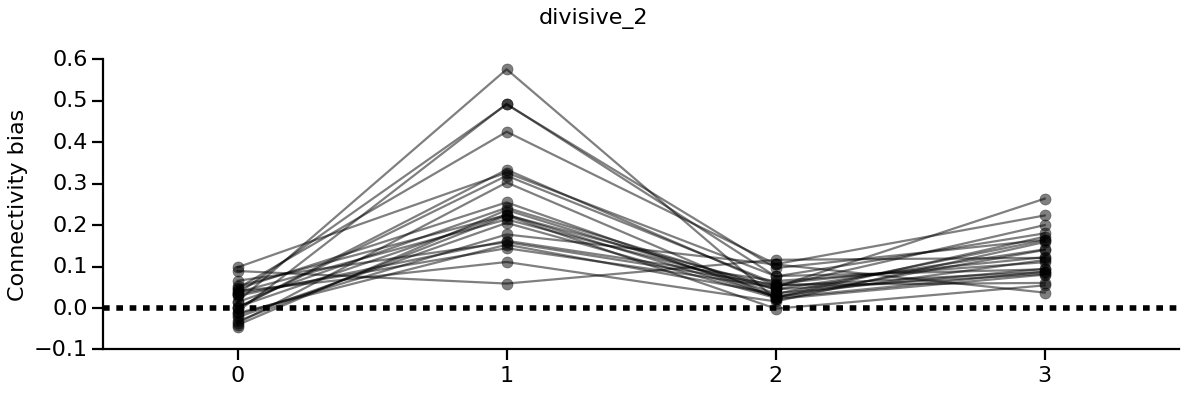

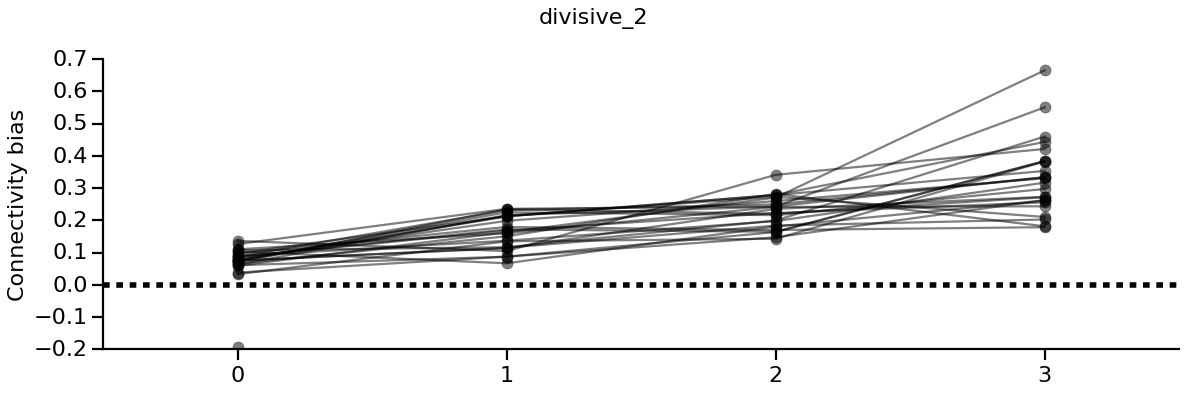

In [5]:
data_fig3d_rule_error_x_rule = {'rule_E_to_error_x_rule': [],
                                  'rule_PV_to_error_x_rule': [],
                                  'error_x_rule_to_rule_E': [],
                                  'error_x_rule_to_rule_PV': []}
data_fig3d_rule_rule = {'rule_E_to_rule_E': [],
                      'rule_PV_to_rule_PV': [],
                      'rule_PV_to_rule_E': [],
                      'rule_E_to_rule_PV': []}

data_suppfig4_rule_error_x_rule = {'rule_E_to_error_x_rule': [],
                                  'rule_PV_to_error_x_rule': [],
                                  'error_x_rule_to_rule_E': [],
                                  'error_x_rule_to_rule_PV': []}
data_suppfig4_rule_rule = {'rule_E_to_rule_E': [],
                          'rule_PV_to_rule_PV': [],
                          'rule_PV_to_rule_E': [],
                          'rule_E_to_rule_PV': []}


for dend_nonlinear in ['subtractive', 'divisive_2']:
    fig, ax = plt.subplots(figsize=[15,5])
    fig.suptitle(dend_nonlinear, fontsize=20)
    fig.patch.set_facecolor('white')
    keys_to_plot = ['bias_ruleesoma_mixerr', 'bias_rulepv_mixerr', 'bias_mixerr_ruleesoma', 'bias_mixerr_rulepv']
    for x in conn_bias_across_networks:
        data = [x[key] for key in keys_to_plot]
        if x['hp']['dend_nonlinearity'] != dend_nonlinear:
            continue
        
        if dend_nonlinear == 'subtractive':
            data_fig3d_rule_error_x_rule['rule_E_to_error_x_rule'].append(data[0])
            data_fig3d_rule_error_x_rule['rule_PV_to_error_x_rule'].append(data[1])
            data_fig3d_rule_error_x_rule['error_x_rule_to_rule_E'].append(data[2])
            data_fig3d_rule_error_x_rule['error_x_rule_to_rule_PV'].append(data[3])
        elif dend_nonlinear == 'divisive_2':
            data_suppfig4_rule_error_x_rule['rule_E_to_error_x_rule'].append(data[0])
            data_suppfig4_rule_error_x_rule['rule_PV_to_error_x_rule'].append(data[1])
            data_suppfig4_rule_error_x_rule['error_x_rule_to_rule_E'].append(data[2])
            data_suppfig4_rule_error_x_rule['error_x_rule_to_rule_PV'].append(data[3])
    
    
        
        ax.plot(data, marker='o', color='k', linewidth=2, markersize=10, alpha=0.5)
    ax.set_xticks(np.arange(len(data)))
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.axhline(y=0, ls='--', color='k', linewidth=5)
    ax.set_xlim(-0.5, len(data)-0.5)
    ax.set_ylabel('Connectivity bias', fontsize=20)
    make_pretty_axes(ax)
    fig.tight_layout()
    plt.show()
    # fig.savefig('/home/yl4317/Documents/two_module_rnn/figs/conn_bias_errorxrule_rule_{}.pdf'.format(dend_nonlinear))
    
    
    ## among the rule cells
    fig, ax = plt.subplots(figsize=[15,5])
    fig.suptitle(dend_nonlinear, fontsize=20)
    fig.patch.set_facecolor('white')
    keys_to_plot = ['bias_ruleesoma_ruleesoma', 'bias_ruleesoma_rulepv', 'bias_rulepv_ruleesoma', 'bias_rulepv_rulepv']
    for x in conn_bias_across_networks:
        if x['hp']['dend_nonlinearity']!=dend_nonlinear:
            continue
        data = [x[key] for key in keys_to_plot]
    
        if dend_nonlinear == 'subtractive':
            data_fig3d_rule_rule['rule_E_to_rule_E'].append(data[0])
            data_fig3d_rule_rule['rule_E_to_rule_PV'].append(data[1])
            data_fig3d_rule_rule['rule_PV_to_rule_E'].append(data[2])
            data_fig3d_rule_rule['rule_PV_to_rule_PV'].append(data[3])
        elif dend_nonlinear == 'divisive_2':
            data_suppfig4_rule_rule['rule_E_to_rule_E'].append(data[0])
            data_suppfig4_rule_rule['rule_E_to_rule_PV'].append(data[1])
            data_suppfig4_rule_rule['rule_PV_to_rule_E'].append(data[2])
            data_suppfig4_rule_rule['rule_PV_to_rule_PV'].append(data[3])

        ax.plot(data, marker='o', color='k', linewidth=2, markersize=10, alpha=0.5)
    ax.set_xticks(np.arange(len(data)))
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.axhline(y=0, ls='--', color='k', linewidth=5)
    ax.set_xlim(-0.5, len(data)-0.5)
    ax.set_ylabel('Connectivity bias', fontsize=20)
    make_pretty_axes(ax)
    fig.tight_layout()
    plt.show()  
    # fig.savefig('/home/yl4317/Documents/two_module_rnn/figs/conn_bias_rule_rule_{}.pdf'.format(dend_nonlinear))
    
# save to csv
# pd.DataFrame.from_dict(data=data_fig3d_rule_error_x_rule, orient='columns').to_csv('/home/yl4317/Documents/two_module_rnn/source_data/fig3d_rule_errxrule.csv', header=False)
# pd.DataFrame.from_dict(data=data_fig3d_rule_rule, orient='columns').to_csv('/home/yl4317/Documents/two_module_rnn/source_data/fig3d_rule_rule.csv', header=False)
# pd.DataFrame.from_dict(data=data_suppfig4_rule_error_x_rule, orient='columns').to_csv('/home/yl4317/Documents/two_module_rnn/source_data/figsuppfig4_rule_errxrule.csv', header=False)
# pd.DataFrame.from_dict(data=data_suppfig4_rule_rule, orient='columns').to_csv('/home/yl4317/Documents/two_module_rnn/source_data/figsuppfig4_rule_rule.csv', header=False)

# Supplementary Figure 5: connectivity biases between E cells and SST cells

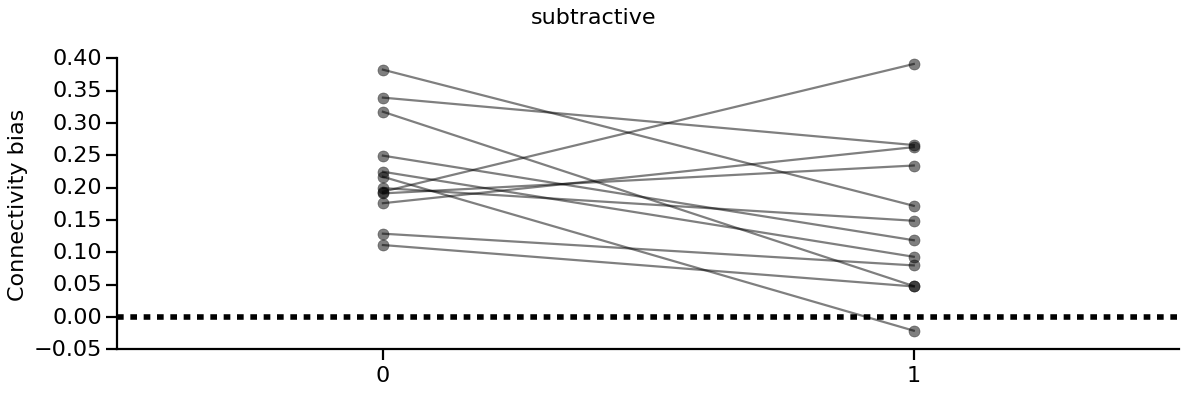

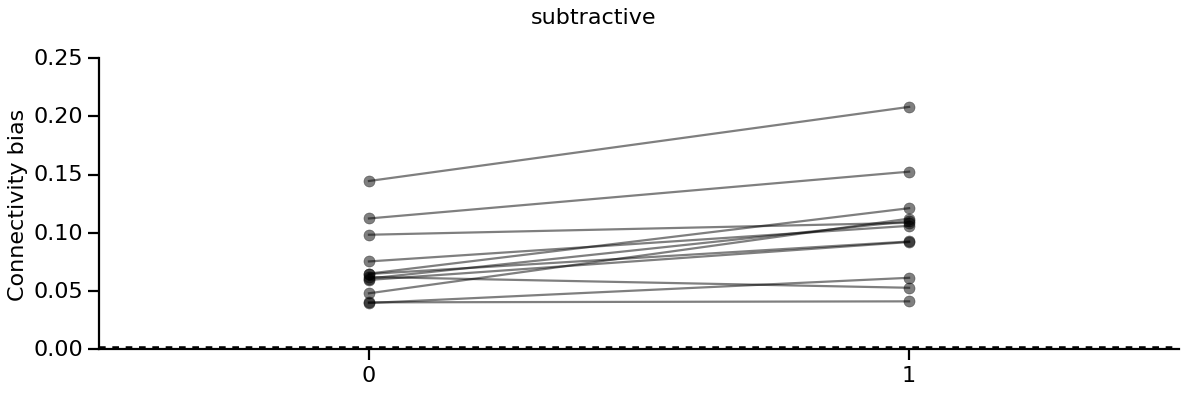

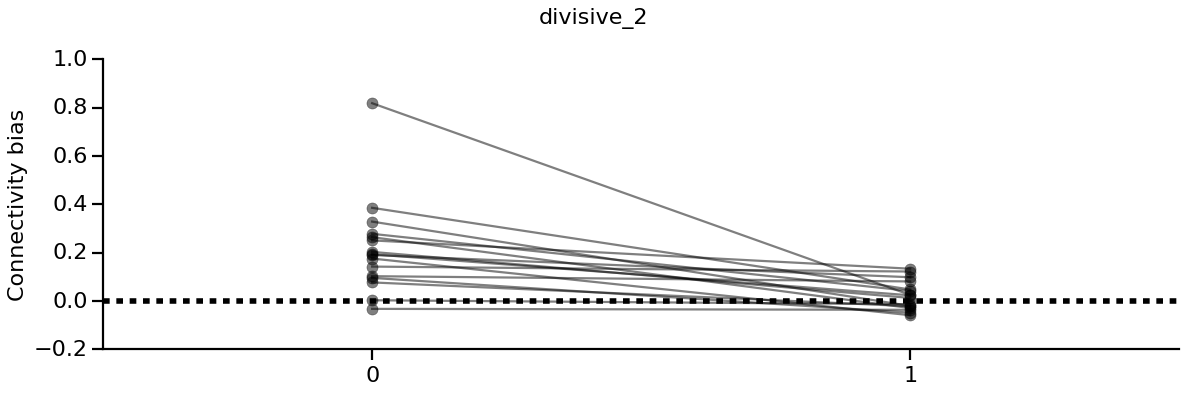

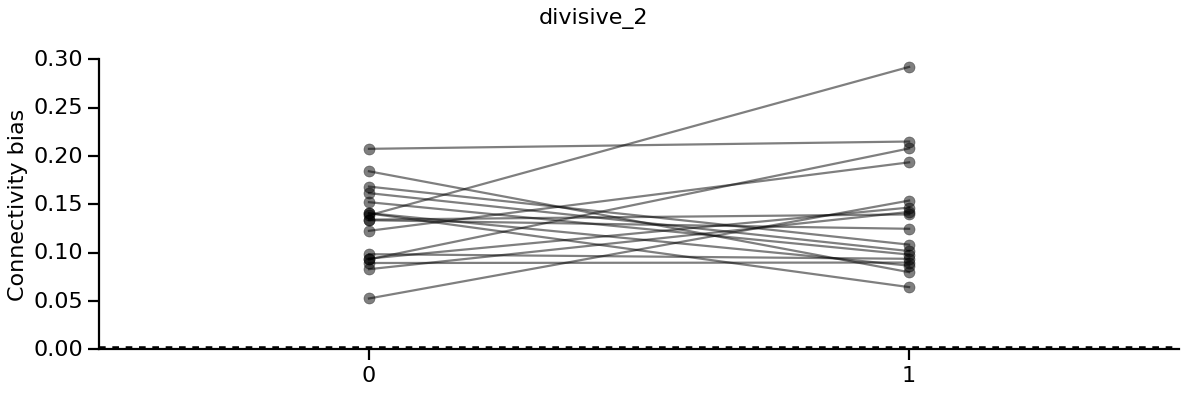

In [6]:
data_suppfig5_divisive = {'SST_to_error_x_rule': [], 'SST_to_rule': [], 'error_x_rule_to_SST': [], 'rule_to_SST': []}
data_suppfig5_subtractive = {'SST_to_error_x_rule': [], 'SST_to_rule': [], 'error_x_rule_to_SST': [], 'rule_to_SST': []}


for dend_nonlinear in ['subtractive', 'divisive_2']:
    fig, ax = plt.subplots(figsize=[15, 5])
    fig.suptitle(dend_nonlinear, fontsize=20)
    fig.patch.set_facecolor('white')
    keys_to_plot = ['bias_rulesst_mixerr', 'bias_mixerr_rulesst']
    for x in conn_bias_across_networks:
        data = [x[key] for key in keys_to_plot]
        if x['hp']['dend_nonlinearity'] != dend_nonlinear:
            continue
        
        if dend_nonlinear == 'subtractive':
            data_suppfig5_subtractive['SST_to_error_x_rule'].append(data[0])
            data_suppfig5_subtractive['error_x_rule_to_SST'].append(data[1])
        elif dend_nonlinear == 'divisive_2':
            data_suppfig5_divisive['SST_to_error_x_rule'].append(data[0])
            data_suppfig5_divisive['error_x_rule_to_SST'].append(data[1])
        
        ax.plot(data, marker='o', color='k', linewidth=2, markersize=10, alpha=0.5)
    ax.set_xticks(np.arange(len(data)))
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.axhline(y=0, ls='--', color='k', linewidth=5)
    ax.set_xlim(-0.5, len(data)-0.5)
    ax.set_ylabel('Connectivity bias', fontsize=20)
    make_pretty_axes(ax)
    fig.tight_layout()
    plt.show()
    # fig.savefig('/home/yl4317/Documents/two_module_rnn/figs/conn_bias_sst_errorxrule_{}.pdf'.format(dend_nonlinear))
    
    
    ## among the rule cells
    fig, ax = plt.subplots(figsize=[15, 5])
    fig.suptitle(dend_nonlinear, fontsize=20)
    fig.patch.set_facecolor('white')
    keys_to_plot = ['bias_rulesst_ruleedend', 'bias_ruleesoma_rulesst']
    for x in conn_bias_across_networks:
        if x['hp']['dend_nonlinearity']!=dend_nonlinear:
            continue
        data = [x[key] for key in keys_to_plot]
    
        if dend_nonlinear == 'subtractive':
            data_suppfig5_subtractive['SST_to_rule'].append(data[0])
            data_suppfig5_subtractive['rule_to_SST'].append(data[1])
        elif dend_nonlinear == 'divisive_2':
            data_suppfig5_divisive['SST_to_rule'].append(data[0])
            data_suppfig5_divisive['rule_to_SST'].append(data[1])

        ax.plot(data, marker='o', color='k', linewidth=2, markersize=10, alpha=0.5)
    ax.set_xticks(np.arange(len(data)))
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.axhline(y=0, ls='--', color='k', linewidth=5)
    ax.set_xlim(-0.5, len(data)-0.5)
    ax.set_ylabel('Connectivity bias', fontsize=20)
    make_pretty_axes(ax)
    fig.tight_layout()
    plt.show()  
    # fig.savefig('/home/yl4317/Documents/two_module_rnn/figs/conn_bias_sst_rule_{}.pdf'.format(dend_nonlinear))
    
# save to csv
# pd.DataFrame.from_dict(data=data_suppfig5_divisive, orient='columns').to_csv('/home/yl4317/Documents/two_module_rnn/source_data/suppfig5_divisive.csv', header=False)
# pd.DataFrame.from_dict(data=data_suppfig5_subtractive, orient='columns').to_csv('/home/yl4317/Documents/two_module_rnn/source_data/suppfig5_subtractive.csv', header=False)

# Supplementary Figure 6b-c: connectivity biases for the slow-switching networks

In [8]:
with open('/home/yl4317/Documents/two_module_rnn/processed_data/conn_bias_slow_switching.pickle', 'rb') as handle:
    conn_bias_across_networks_slow = pickle.load(handle)

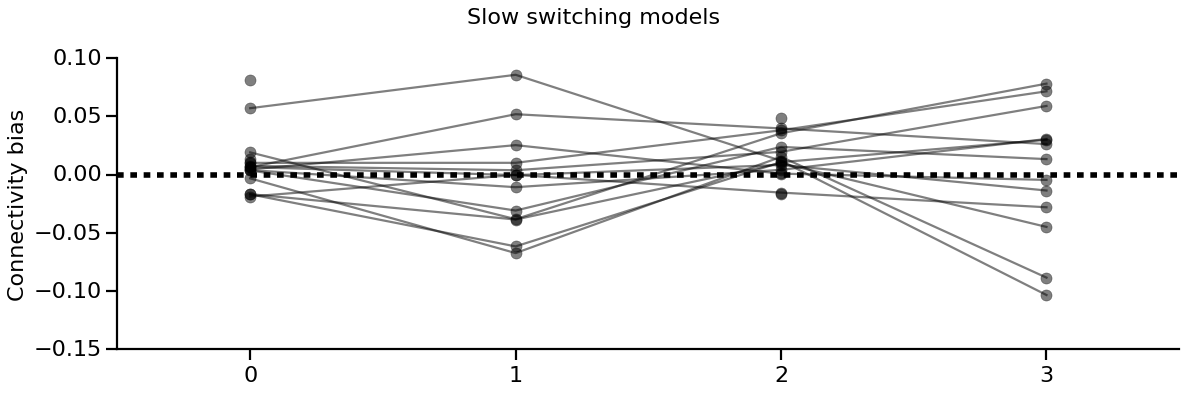

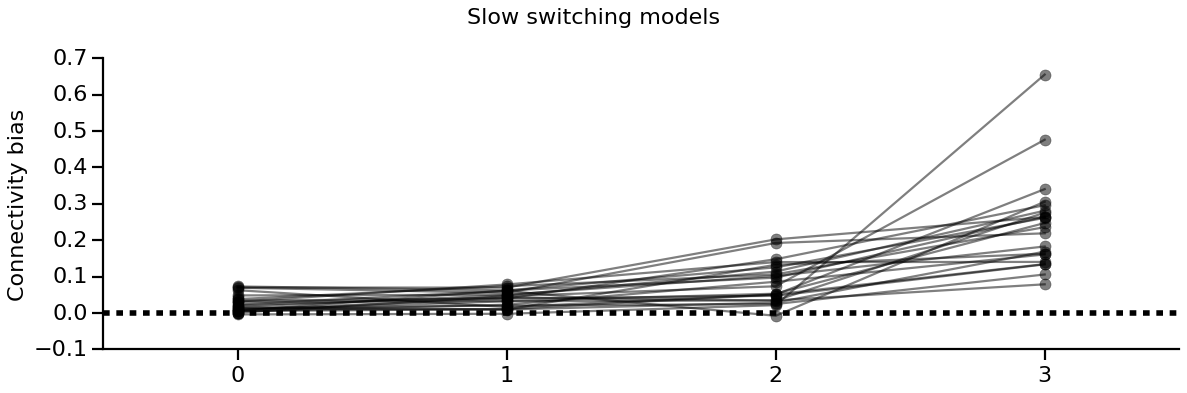

In [9]:
data_suppfig6b_rule_error_x_rule = {'rule_E_to_error_x_rule': [],
                                  'rule_PV_to_error_x_rule': [],
                                  'error_x_rule_to_rule_E': [],
                                  'error_x_rule_to_rule_PV': []}
data_suppfig6c_rule_rule = {'rule_E_to_rule_E': [],
                          'rule_PV_to_rule_PV': [],
                          'rule_PV_to_rule_E': [],
                          'rule_E_to_rule_PV': []}


fig, ax = plt.subplots(figsize=[15,5])
fig.suptitle('Slow switching models', fontsize=20)
fig.patch.set_facecolor('white')
keys_to_plot = ['bias_ruleesoma_mixerr', 'bias_rulepv_mixerr', 'bias_mixerr_ruleesoma', 'bias_mixerr_rulepv']
for x in conn_bias_across_networks_slow:
    data = [x[key] for key in keys_to_plot]
    
    data_suppfig6b_rule_error_x_rule['rule_E_to_error_x_rule'].append(data[0])
    data_suppfig6b_rule_error_x_rule['rule_PV_to_error_x_rule'].append(data[1])
    data_suppfig6b_rule_error_x_rule['error_x_rule_to_rule_E'].append(data[2])
    data_suppfig6b_rule_error_x_rule['error_x_rule_to_rule_PV'].append(data[3])

    ax.plot(data, marker='o', color='k', linewidth=2, markersize=10, alpha=0.5)
ax.set_xticks(np.arange(len(data)))
ax.tick_params(axis='both', which='major', labelsize=15)
ax.axhline(y=0, ls='--', color='k', linewidth=5)
ax.set_xlim(-0.5, len(data)-0.5)
ax.set_ylabel('Connectivity bias', fontsize=20)
make_pretty_axes(ax)
fig.tight_layout()
plt.show()
# fig.savefig('/home/yl4317/Documents/two_module_rnn/figs/conn_bias_errorxrule_rule_slow.pdf')


## among the rule cells
fig, ax = plt.subplots(figsize=[15,5])
fig.suptitle('Slow switching models', fontsize=20)
fig.patch.set_facecolor('white')
keys_to_plot = ['bias_ruleesoma_ruleesoma', 'bias_ruleesoma_rulepv', 'bias_rulepv_ruleesoma', 'bias_rulepv_rulepv']
for x in conn_bias_across_networks_slow:
    data = [x[key] for key in keys_to_plot]

    data_suppfig6c_rule_rule['rule_E_to_rule_E'].append(data[0])
    data_suppfig6c_rule_rule['rule_E_to_rule_PV'].append(data[1])
    data_suppfig6c_rule_rule['rule_PV_to_rule_E'].append(data[2])
    data_suppfig6c_rule_rule['rule_PV_to_rule_PV'].append(data[3])
    

    ax.plot(data, marker='o', color='k', linewidth=2, markersize=10, alpha=0.5)
ax.set_xticks(np.arange(len(data)))
ax.tick_params(axis='both', which='major', labelsize=20)
ax.axhline(y=0, ls='--', color='k', linewidth=5)
ax.set_xlim(-0.5, len(data)-0.5)
ax.set_ylabel('Connectivity bias', fontsize=20)
make_pretty_axes(ax)
fig.tight_layout()
plt.show()  
# fig.savefig('/home/yl4317/Documents/two_module_rnn/figs/conn_bias_rule_rule_slow.pdf')
    
# save to csv
# pd.DataFrame.from_dict(data=data_suppfig6b_rule_error_x_rule, orient='columns').to_csv('/home/yl4317/Documents/two_module_rnn/source_data/suppfig6b_rule_errxrule.csv', header=False)
# pd.DataFrame.from_dict(data=data_suppfig6c_rule_rule, orient='columns').to_csv('/home/yl4317/Documents/two_module_rnn/source_data/suppfig6c_rule_rule.csv', header=False)